In [1]:
import random
import numpy as np
import math
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import seaborn as sns
%matplotlib inline
import matplotlib.style as style
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

import torch
import copy
import bisect

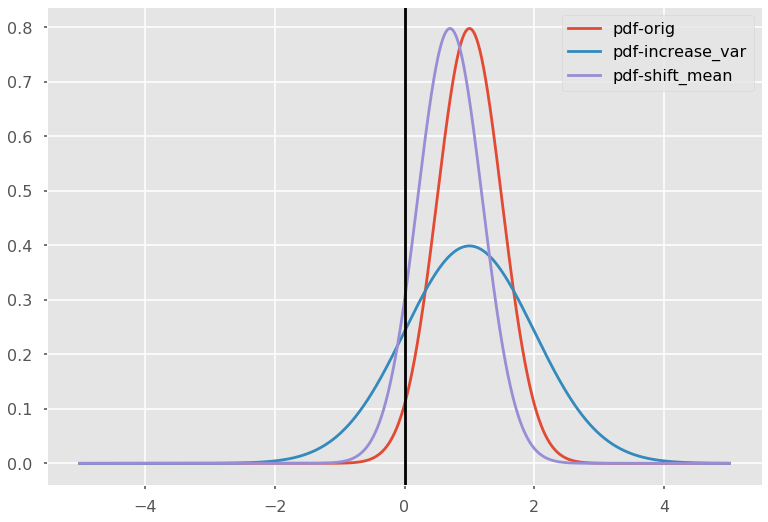

In [2]:
x = np.linspace(-5, 5, 5000)
mu = 0
sigma = 1

# y_pdf = stats.norm.pdf(x, mu, sigma)
y_pdf1 = stats.norm.pdf(x, 0, 1)
# y_pdf2 = stats.norm.pdf(x, 0, 1.2)
y_pdf2 = stats.norm.pdf(x, 0, 2)
y_pdf3 = stats.norm.pdf(x, 1.0, 0.5)
y_pdf4 = stats.norm.pdf(x,1.0, 1.0)
y_pdf5 = stats.norm.pdf(x, 0.7, 0.5)

# plt.plot(x, y_pdf1, label='pdf1')
# plt.plot(x, y_pdf2, label='pdf2')
plt.plot(x, y_pdf3, label='pdf-orig')
plt.plot(x, y_pdf4, label='pdf-increase_var')
plt.plot(x, y_pdf5, label='pdf-shift_mean')
plt.axvline(x=0, color='black', linestyle='-')
plt.legend()

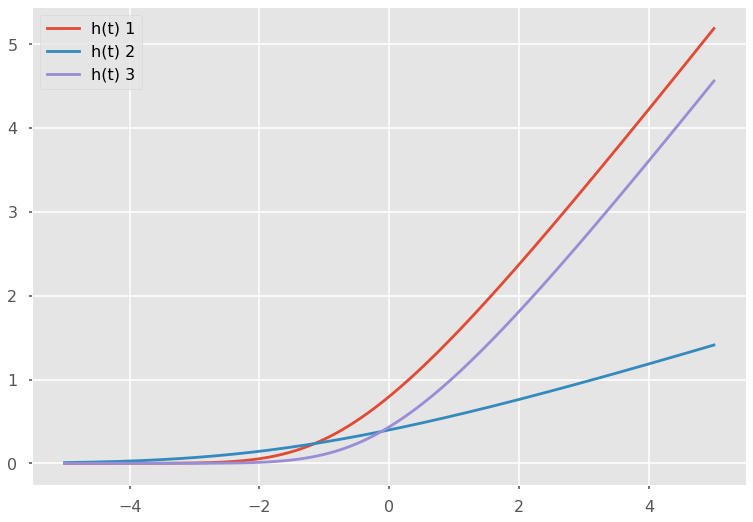

In [3]:
x = np.linspace(-5, 5, 5000)

# y_pdf = stats.norm.pdf(x, mu, sigma)
y_pdf1 = stats.norm.pdf(x, 0, 1)
y_sf1 = stats.norm.sf(x, 0, 1)
y_pdf2 = stats.norm.pdf(x, 0, 2)
y_sf2 = stats.norm.sf(x, 0, 2)
y_pdf3 = stats.norm.pdf(x, 0.65, 1)
y_sf3 = stats.norm.sf(x, 0.65, 1)

h1 = [f/s for f, s in zip(y_pdf1, y_sf1)]
h2 = [f/s for f, s in zip(y_pdf2, y_sf2)]
h3 = [f/s for f, s in zip(y_pdf3, y_sf3)]

plt.plot(x, h1, label='h(t) 1')
plt.plot(x, h2, label='h(t) 2')
plt.plot(x, h3, label='h(t) 3')
plt.legend()

In [4]:
# Node for each hs and counter, see the flipflop between
min_time = -10
time_points = np.linspace(min_time, 10, 800)
delta = time_points[1] - time_points[0]
class Node:
    def __init__(self, uid, hazard, goal, c=1.0):
        self.uid = uid
        self.c = c
        self.index = 0
        self.hazard = hazard
        self.goal = goal
        self.min_steps = int(round((self.goal - min_time) / delta))
        
    def reset(self):
        self.index = 0
        
    def minSteps(self):
        return self.min_steps
        
    def cost(self):
#         return ((self.index + 1) * self.c) / self.hazard[self.index]
#         return (self.hazard[self.index + 1] - self.hazard[self.index]) / ((self.index + 1)**1 * self.c)
        return (self.hazard[self.index]) / ((self.index + 1) ** self.c)
#         return ((self.index + 1) * self.c) / self.hazard[self.index]
#         return self.hazard[self.index] / ((self.index + 1) * self.c)
    
    def isGoal(self):
        return time_points[self.index] >= self.goal
    
    def expand(self):
        self.index += 1
        
    def getUID(self):
        return self.uid
    
    def getIndex(self):
        return self.index
        
    def __str__(self):
        return 'uid={}\t idx={:5d}\t hazard={:8.3f}\t cost={:10.5f}\t t={:8.5f}\t goal={:7.5f}\t min_steps={:d}, '.format(
            self.uid, self.index, self.hazard[self.index], self.cost(), time_points[self.index], self.goal, self.min_steps
        )

In [5]:
def printVerb(msg, verb):
    if verb:
        print(msg)

def LevinTS(nodes, verbose=True):
    best_time = min(nodes, key=lambda x : x.minSteps()).minSteps()
    printVerb('Best possible time: {}'.format(best_time), verbose)
    printVerb('Nodes:', verbose)
    for node in nodes:
        printVerb(node, verbose)

    current_node = None
    node_history = []
    counter = 0
    while True:
        min_node = max(nodes, key=lambda x : x.cost())
        min_node.expand()
        counter += 1

        # Node swap
        if len(node_history) == 0 or node_history[-1][0] != min_node.getUID():
            node_history.append((min_node.getUID(), str(min_node)))

        if min_node.isGoal():
            global_efficiency = best_time / counter
            local_efficiency = min_node.getIndex() / counter
            printVerb('', verbose)
            printVerb('Found solution at global step: {}'.format(counter), verbose)
            printVerb('Global efficiency: {:.4f}'.format(global_efficiency), verbose)
            printVerb('Local efficiency: {:.4f}'.format(local_efficiency), verbose)
            printVerb(min_node, verbose)
            
            return global_efficiency, local_efficiency, node_history

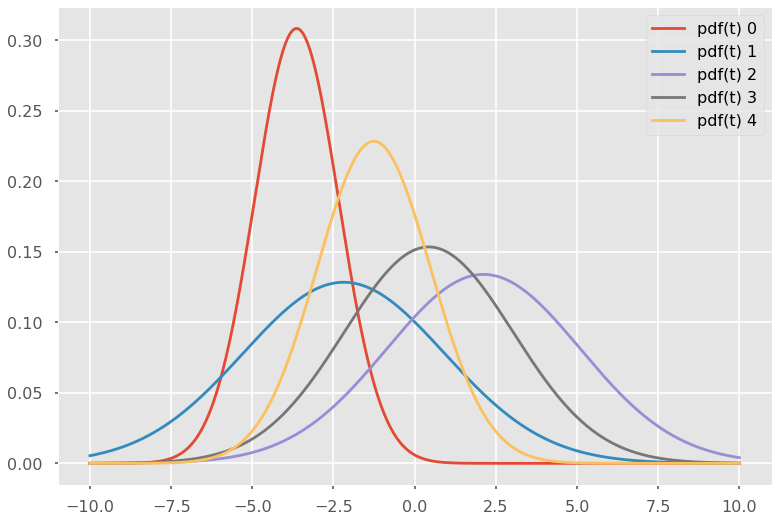

In [6]:
epsilon = 1e-8
NUM_INSTANCES = 5
# mus = [2*random.uniform(0,1) for _ in range(NUM_INSTANCES)]
mus = [random.choice(time_points) / 2 for _ in range(NUM_INSTANCES)]
sigmas = [5*(random.uniform(0,1) + epsilon) / 1 for _ in range(NUM_INSTANCES)]
# sigmas = [1 for _ in range(NUM_INSTANCES)]
pdfs = [stats.norm.pdf(time_points, m, s) for m, s in zip(mus, sigmas)]
sfs = [stats.norm.sf(time_points, m, s) for m, s in zip(mus, sigmas)]
# hs = []
# for pdf, sf in zip(pdfs, sfs):
#     hs.append([np.exp(np.log(f) - np.log(s)) if s == 0 else f/s for f, s in zip(pdf, sf)])
hs = [[np.exp(np.log(f) - np.log(s)) for f, s in zip(pdf, sf)] for (pdf, sf) in zip(pdfs, sfs)]
# hs = [[np.log(1.0/ (1+np.exp(np.log(f) - np.log(s)))) for f, s in zip(pdf, sf)] for (pdf, sf) in zip(pdfs, sfs)]
for i, pdf in enumerate(pdfs):
    plt.plot(time_points, pdf, label='pdf(t) {}'.format(i))
plt.legend()

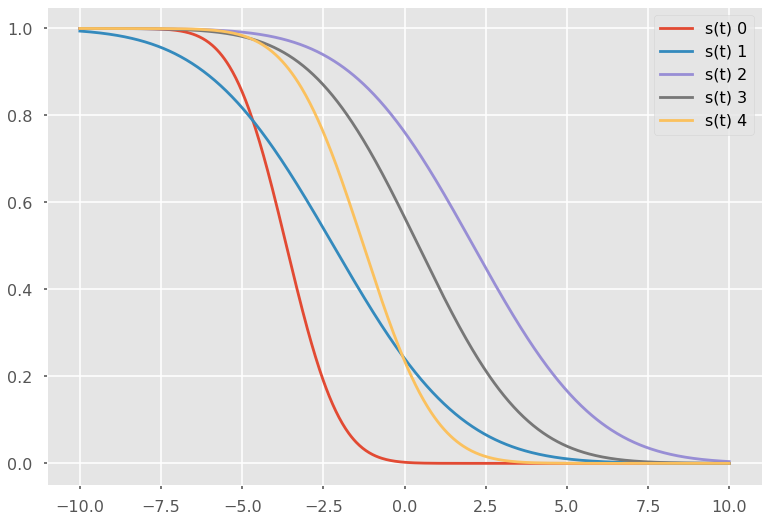

In [7]:
for i, s in enumerate(sfs):
    plt.plot(time_points, s, label='s(t) {}'.format(i))
plt.legend()

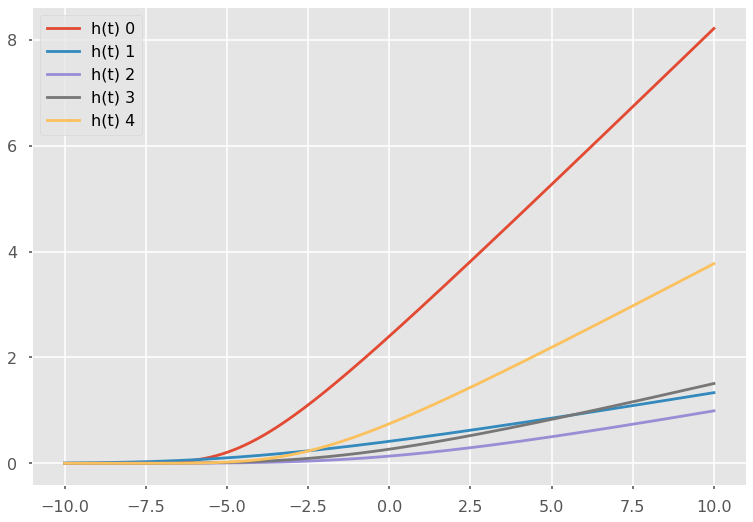

In [8]:
for i, h in enumerate(hs):
#     plt.plot(time_points, [np.log(1.0/ (1+h_)) for h_ in h], label='h(t) {}'.format(i))
    plt.plot(time_points, h, label='h(t) {}'.format(i))
plt.legend()

In [9]:
global_efficiencies = []
local_efficiencies = []
verbose = True
for _ in range(1):
    goals = [np.random.randn() * s + m for m, s in zip(mus, sigmas)]
#     goals = [m/s for m, s in zip(mus, sigmas)]
    nodes = [Node(i, h, g, 0.5) for i, (h, g) in enumerate(zip(hs, goals))]
    global_efficiency, local_efficiency, node_history = LevinTS(nodes, verbose=verbose)
    global_efficiencies.append(global_efficiency)
    local_efficiencies.append(local_efficiency)
    if verbose:
        print('-----------------------')
        print('Open list history of swaps')
        for node in node_history:
            print(node[1])

global_avg = sum(global_efficiencies) / len(global_efficiencies)
local_avg = sum(local_efficiencies) / len(local_efficiencies)
print('Average global efficiency: {}'.format(global_avg))
print('Average local efficiency: {}'.format(local_avg))

Best possible time: 60
Nodes:
uid=0	 idx=    0	 hazard=   0.000	 cost=   0.00000	 t=-10.00000	 goal=-4.76381	 min_steps=209, 
uid=1	 idx=    0	 hazard=   0.005	 cost=   0.00547	 t=-10.00000	 goal=-8.48756	 min_steps=60, 
uid=2	 idx=    0	 hazard=   0.000	 cost=   0.00003	 t=-10.00000	 goal=3.54366	 min_steps=541, 
uid=3	 idx=    0	 hazard=   0.000	 cost=   0.00005	 t=-10.00000	 goal=4.93158	 min_steps=597, 
uid=4	 idx=    0	 hazard=   0.000	 cost=   0.00000	 t=-10.00000	 goal=-2.25693	 min_steps=309, 

Found solution at global step: 61
Global efficiency: 0.9836
Local efficiency: 1.0000
uid=1	 idx=   61	 hazard=   0.017	 cost=   0.00215	 t=-8.47309	 goal=-8.48756	 min_steps=60, 
-----------------------
Open list history of swaps
uid=1	 idx=    1	 hazard=   0.006	 cost=   0.00395	 t=-9.97497	 goal=-8.48756	 min_steps=60, 
Average global efficiency: 0.9836065573770492
Average local efficiency: 1.0


# Model output histogram

In [344]:
model1 = torch.jit.load('../src/export/Bayesian/bayesian_key_lb00_1.pt')
model2 = torch.jit.load('../src/export/Bayesian/bayesian_key_lb20_1.pt')
model3 = torch.jit.load('../src/export/Bayesian/bayesian_key_lb50_1.pt')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
FEAT_MEAN_0 = 0.0325
FEAT_MEAN_1 = 0.0197
FEAT_STDEV_0 = 0.1056
FEAT_STDEV_1 = 0.1124

In [10]:
def graphObservations(all_data, t=None, max_el=None):
    fig, ax = plt.subplots()
    kwargs = {'cumulative': True}
#     sns.distplot(x, hist_kws=kwargs, kde_kws=kwargs)
    for d, l in all_data:
        if max_el:
            sns.distplot([i for i in d if i < max_el], label=l)
        else:
#             sns.distplot(d, label=l)
            sns.distplot(d, label=l, bins=20, kde_kws=kwargs)
    if t:
        plt.axvline(x=t, color='black', linestyle='-')
    plt.legend()

In [255]:
def preprocessLevel(level_data):
    FEAT_MEAN_0 = 0.0325
    FEAT_MEAN_1 = 0.0197
    FEAT_STDEV_0 = 0.1056
    FEAT_STDEV_1 = 0.1124
    level_data[0].sub_(FEAT_MEAN_0)
    level_data[0].div_(FEAT_STDEV_0)
    level_data[1].sub_(FEAT_MEAN_1)
    level_data[1].div_(FEAT_STDEV_1)
    
def getHistorgramValue(hist, bin_edges, x):
    if x < bin_edges[0]:
        return float(hist[0]) / sum(hist)
    elif x > bin_edges[-1]:
        return float(hist[-1]) / sum(hist)
    else:
        return float(hist[np.argmax(bin_edges > x) - 1]) / sum(hist)
    
def ecdfAll(data):
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return [(xi,yi) for xi, yi in zip(x,y)]


def getECDF(data, x):
    x_ = np.sort(data)
    n = x_.size
    y = np.arange(1, n+1) / n
    if x < x_[0]:
        return y[0]* 0.999
    elif x > x_[-1]:
        return y[-1]* 0.999
    else:
        return y[np.argmax(x_ > x) - 1] * 0.999

In [352]:
# Get specific high level path and standardize
levels = [('train5_657', 0, 'sol'), ('train5_657', 0, 'lb')]
level_data = [torch.load('../../training_data/{}_feature.zip'.format(l))[r] for (l, r, _) in levels]
for hlp in level_data:
    hlp[0].sub_(FEAT_MEAN_0)
    hlp[0].div_(FEAT_STDEV_0)
    hlp[1].sub_(FEAT_MEAN_1)
    hlp[1].div_(FEAT_STDEV_1)

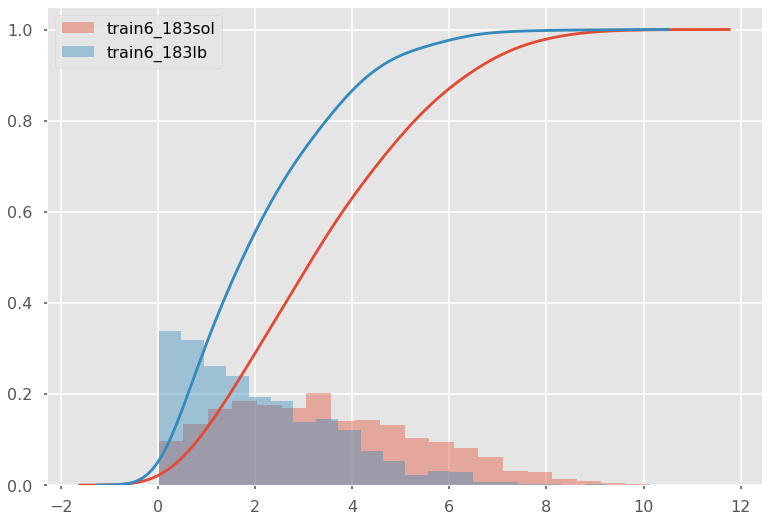

In [237]:
all_time_points = []
for l, data in zip(levels, level_data):
    time_points = []
    for _ in range(1000):
        time_points.append(model1(torch.stack([data], 0).to(device))[0].item())
    all_time_points.append([time_points, l[0] + l[2]])
graphObservations(all_time_points)

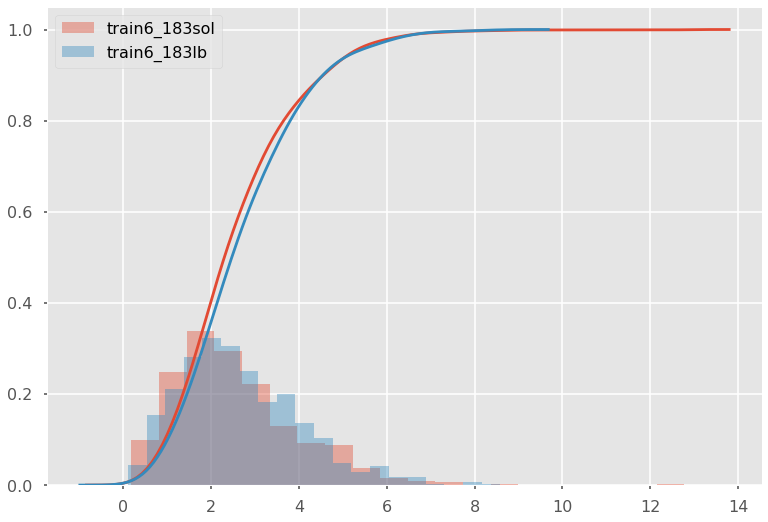

In [238]:
all_time_points = []
for l, data in zip(levels, level_data):
    time_points = []
    for _ in range(1000):
        time_points.append(model2(torch.stack([data], 0).to(device))[0].item())
    all_time_points.append([time_points, l[0] + l[2]])
graphObservations(all_time_points)

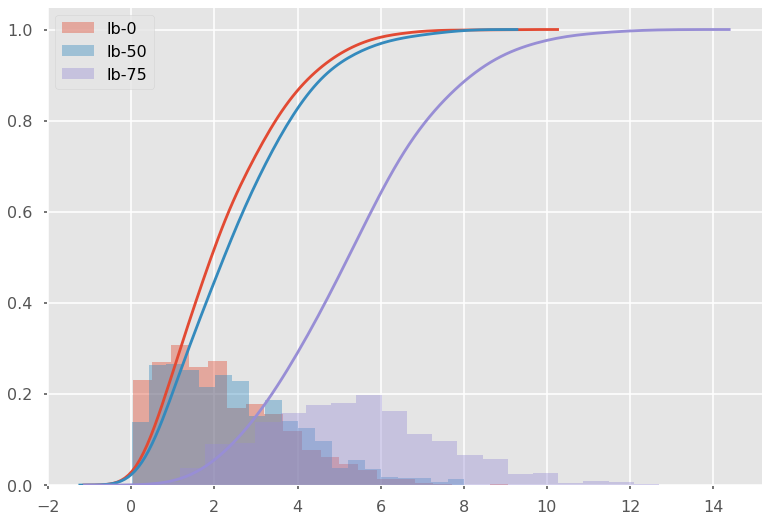

In [353]:
# Compare models sol
all_time_points = []
models = [model1, model2, model3]
model_names = ['lb-0', 'lb-50', 'lb-75']
for model, name in zip(models, model_names):
    time_points = []
    for _ in range(1000):
        time_points.append(model(torch.stack([level_data[0]], 0).to(device))[0].item())
    all_time_points.append([time_points, name])
graphObservations(all_time_points)

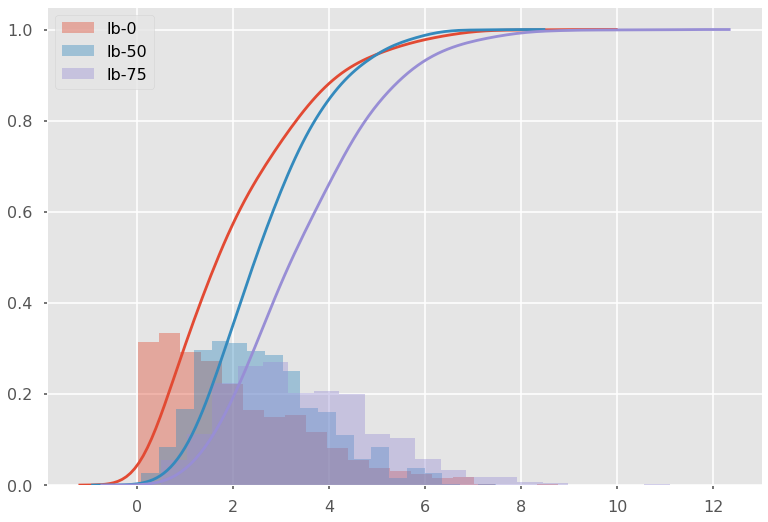

In [240]:
# Compare models lb
all_time_points = []
models = [model1, model2, model3]
model_names = ['lb-0', 'lb-50', 'lb-75']
for model, name in zip(models, model_names):
    time_points = []
    for _ in range(1000):
        time_points.append(model(torch.stack([level_data[1]], 0).to(device))[0].item())
    all_time_points.append([time_points, name])
graphObservations(all_time_points)

In [270]:
# Small p value means we reject null at level p = alpha (0.05) i.e. 
stats.ks_2samp(all_time_points[0][0], all_time_points[2][0], alternative='greater')

Ks_2sampResult(statistic=0.252, pvalue=1.3652971227410825e-28)

# Compare KS for various levels of lower bound data (Bayes)

In [119]:
MODEL_DIR = '../src/export/Bayesian/'
DATA_DIR = '../../training_data/{}_feature.zip'
BASE_FILE = 'bayesian_key_lb{}_{}'
LBS = ['00', '20', '40', '50', '60', '80']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
NUM_FOLDS = 5
NUM_SAMPLES = 500

In [120]:
def getResultsForFoldBayes(k, results_dict):
    
    # Load level file
    level_files = open(MODEL_DIR + BASE_FILE.format('00', k+1) + '.txt', "r")
    # Count lines:
    counter = 0
    for level in level_files:
        counter += 1
    
    level_files.seek(0)
    for i, level in enumerate(level_files):
        print("Level {} of {}".format(i, counter))
        results_dict[level.strip()] = []
        # Get data
        level_data = torch.load(DATA_DIR.format(level.strip()))[0]
        preprocessLevel(level_data)
        
        # Load models
        all_timepoints = []
        for LB in LBS:
            model = torch.jit.load(MODEL_DIR + BASE_FILE.format(LB, k+1) + '.pt')

            # Sample level from model
            time_points = []
            for _ in range(100):
                time_points.append(model(torch.stack([level_data], 0).to(device))[0].item())
            all_timepoints.append(time_points)
        
        # Time points stored for each model, now we compare each to default model and compare KS 
        for i, LB in enumerate(LBS[1:]):
            ks = stats.ks_2samp(all_timepoints[0], all_timepoints[i+1], alternative='greater')
            results_dict[level.strip()].append(ks)
        
        del level_data
    return results_dict

In [322]:
KS_results_all = {}
# # KS_results_all = copy.deepcopy(KS_results)
for i in range(NUM_FOLDS):
    KS_results_all = getResultsForFoldBayes(i, KS_results_all)

Level 0 of 1188
Level 1 of 1188
Level 2 of 1188
Level 3 of 1188
Level 4 of 1188
Level 5 of 1188
Level 6 of 1188
Level 7 of 1188
Level 8 of 1188
Level 9 of 1188
Level 10 of 1188
Level 11 of 1188
Level 12 of 1188
Level 13 of 1188
Level 14 of 1188
Level 15 of 1188
Level 16 of 1188
Level 17 of 1188
Level 18 of 1188
Level 19 of 1188
Level 20 of 1188
Level 21 of 1188
Level 22 of 1188
Level 23 of 1188
Level 24 of 1188
Level 25 of 1188
Level 26 of 1188
Level 27 of 1188
Level 28 of 1188
Level 29 of 1188
Level 30 of 1188
Level 31 of 1188
Level 32 of 1188
Level 33 of 1188
Level 34 of 1188
Level 35 of 1188
Level 36 of 1188
Level 37 of 1188
Level 38 of 1188
Level 39 of 1188
Level 40 of 1188
Level 41 of 1188
Level 42 of 1188
Level 43 of 1188
Level 44 of 1188
Level 45 of 1188
Level 46 of 1188
Level 47 of 1188
Level 48 of 1188
Level 49 of 1188
Level 50 of 1188
Level 51 of 1188
Level 52 of 1188
Level 53 of 1188
Level 54 of 1188
Level 55 of 1188
Level 56 of 1188
Level 57 of 1188
Level 58 of 1188
Level 5

Level 462 of 1188
Level 463 of 1188
Level 464 of 1188
Level 465 of 1188
Level 466 of 1188
Level 467 of 1188
Level 468 of 1188
Level 469 of 1188
Level 470 of 1188
Level 471 of 1188
Level 472 of 1188
Level 473 of 1188
Level 474 of 1188
Level 475 of 1188
Level 476 of 1188
Level 477 of 1188
Level 478 of 1188
Level 479 of 1188
Level 480 of 1188
Level 481 of 1188
Level 482 of 1188
Level 483 of 1188
Level 484 of 1188
Level 485 of 1188
Level 486 of 1188
Level 487 of 1188
Level 488 of 1188
Level 489 of 1188
Level 490 of 1188
Level 491 of 1188
Level 492 of 1188
Level 493 of 1188
Level 494 of 1188
Level 495 of 1188
Level 496 of 1188
Level 497 of 1188
Level 498 of 1188
Level 499 of 1188
Level 500 of 1188
Level 501 of 1188
Level 502 of 1188
Level 503 of 1188
Level 504 of 1188
Level 505 of 1188
Level 506 of 1188
Level 507 of 1188
Level 508 of 1188
Level 509 of 1188
Level 510 of 1188
Level 511 of 1188
Level 512 of 1188
Level 513 of 1188
Level 514 of 1188
Level 515 of 1188
Level 516 of 1188
Level 517 

Level 918 of 1188
Level 919 of 1188
Level 920 of 1188
Level 921 of 1188
Level 922 of 1188
Level 923 of 1188
Level 924 of 1188
Level 925 of 1188
Level 926 of 1188
Level 927 of 1188
Level 928 of 1188
Level 929 of 1188
Level 930 of 1188
Level 931 of 1188
Level 932 of 1188
Level 933 of 1188
Level 934 of 1188
Level 935 of 1188
Level 936 of 1188
Level 937 of 1188
Level 938 of 1188
Level 939 of 1188
Level 940 of 1188
Level 941 of 1188
Level 942 of 1188
Level 943 of 1188
Level 944 of 1188
Level 945 of 1188
Level 946 of 1188
Level 947 of 1188
Level 948 of 1188
Level 949 of 1188
Level 950 of 1188
Level 951 of 1188
Level 952 of 1188
Level 953 of 1188
Level 954 of 1188
Level 955 of 1188
Level 956 of 1188
Level 957 of 1188
Level 958 of 1188
Level 959 of 1188
Level 960 of 1188
Level 961 of 1188
Level 962 of 1188
Level 963 of 1188
Level 964 of 1188
Level 965 of 1188
Level 966 of 1188
Level 967 of 1188
Level 968 of 1188
Level 969 of 1188
Level 970 of 1188
Level 971 of 1188
Level 972 of 1188
Level 973 

Level 181 of 1188
Level 182 of 1188
Level 183 of 1188
Level 184 of 1188
Level 185 of 1188
Level 186 of 1188
Level 187 of 1188
Level 188 of 1188
Level 189 of 1188
Level 190 of 1188
Level 191 of 1188
Level 192 of 1188
Level 193 of 1188
Level 194 of 1188
Level 195 of 1188
Level 196 of 1188
Level 197 of 1188
Level 198 of 1188
Level 199 of 1188
Level 200 of 1188
Level 201 of 1188
Level 202 of 1188
Level 203 of 1188
Level 204 of 1188
Level 205 of 1188
Level 206 of 1188
Level 207 of 1188
Level 208 of 1188
Level 209 of 1188
Level 210 of 1188
Level 211 of 1188
Level 212 of 1188
Level 213 of 1188
Level 214 of 1188
Level 215 of 1188
Level 216 of 1188
Level 217 of 1188
Level 218 of 1188
Level 219 of 1188
Level 220 of 1188
Level 221 of 1188
Level 222 of 1188
Level 223 of 1188
Level 224 of 1188
Level 225 of 1188
Level 226 of 1188
Level 227 of 1188
Level 228 of 1188
Level 229 of 1188
Level 230 of 1188
Level 231 of 1188
Level 232 of 1188
Level 233 of 1188
Level 234 of 1188
Level 235 of 1188
Level 236 

Level 637 of 1188
Level 638 of 1188
Level 639 of 1188
Level 640 of 1188
Level 641 of 1188
Level 642 of 1188
Level 643 of 1188
Level 644 of 1188
Level 645 of 1188
Level 646 of 1188
Level 647 of 1188
Level 648 of 1188
Level 649 of 1188
Level 650 of 1188
Level 651 of 1188
Level 652 of 1188
Level 653 of 1188
Level 654 of 1188
Level 655 of 1188
Level 656 of 1188
Level 657 of 1188
Level 658 of 1188
Level 659 of 1188
Level 660 of 1188
Level 661 of 1188
Level 662 of 1188
Level 663 of 1188
Level 664 of 1188
Level 665 of 1188
Level 666 of 1188
Level 667 of 1188
Level 668 of 1188
Level 669 of 1188
Level 670 of 1188
Level 671 of 1188
Level 672 of 1188
Level 673 of 1188
Level 674 of 1188
Level 675 of 1188
Level 676 of 1188
Level 677 of 1188
Level 678 of 1188
Level 679 of 1188
Level 680 of 1188
Level 681 of 1188
Level 682 of 1188
Level 683 of 1188
Level 684 of 1188
Level 685 of 1188
Level 686 of 1188
Level 687 of 1188
Level 688 of 1188
Level 689 of 1188
Level 690 of 1188
Level 691 of 1188
Level 692 

Level 1088 of 1188
Level 1089 of 1188
Level 1090 of 1188
Level 1091 of 1188
Level 1092 of 1188
Level 1093 of 1188
Level 1094 of 1188
Level 1095 of 1188
Level 1096 of 1188
Level 1097 of 1188
Level 1098 of 1188
Level 1099 of 1188
Level 1100 of 1188
Level 1101 of 1188
Level 1102 of 1188
Level 1103 of 1188
Level 1104 of 1188
Level 1105 of 1188
Level 1106 of 1188
Level 1107 of 1188
Level 1108 of 1188
Level 1109 of 1188
Level 1110 of 1188
Level 1111 of 1188
Level 1112 of 1188
Level 1113 of 1188
Level 1114 of 1188
Level 1115 of 1188
Level 1116 of 1188
Level 1117 of 1188
Level 1118 of 1188
Level 1119 of 1188
Level 1120 of 1188
Level 1121 of 1188
Level 1122 of 1188
Level 1123 of 1188
Level 1124 of 1188
Level 1125 of 1188
Level 1126 of 1188
Level 1127 of 1188
Level 1128 of 1188
Level 1129 of 1188
Level 1130 of 1188
Level 1131 of 1188
Level 1132 of 1188
Level 1133 of 1188
Level 1134 of 1188
Level 1135 of 1188
Level 1136 of 1188
Level 1137 of 1188
Level 1138 of 1188
Level 1139 of 1188
Level 1140 o

Level 356 of 1188
Level 357 of 1188
Level 358 of 1188
Level 359 of 1188
Level 360 of 1188
Level 361 of 1188
Level 362 of 1188
Level 363 of 1188
Level 364 of 1188
Level 365 of 1188
Level 366 of 1188
Level 367 of 1188
Level 368 of 1188
Level 369 of 1188
Level 370 of 1188
Level 371 of 1188
Level 372 of 1188
Level 373 of 1188
Level 374 of 1188
Level 375 of 1188
Level 376 of 1188
Level 377 of 1188
Level 378 of 1188
Level 379 of 1188
Level 380 of 1188
Level 381 of 1188
Level 382 of 1188
Level 383 of 1188
Level 384 of 1188
Level 385 of 1188
Level 386 of 1188
Level 387 of 1188
Level 388 of 1188
Level 389 of 1188
Level 390 of 1188
Level 391 of 1188
Level 392 of 1188
Level 393 of 1188
Level 394 of 1188
Level 395 of 1188
Level 396 of 1188
Level 397 of 1188
Level 398 of 1188
Level 399 of 1188
Level 400 of 1188
Level 401 of 1188
Level 402 of 1188
Level 403 of 1188
Level 404 of 1188
Level 405 of 1188
Level 406 of 1188
Level 407 of 1188
Level 408 of 1188
Level 409 of 1188
Level 410 of 1188
Level 411 

Level 812 of 1188
Level 813 of 1188
Level 814 of 1188
Level 815 of 1188
Level 816 of 1188
Level 817 of 1188
Level 818 of 1188
Level 819 of 1188
Level 820 of 1188
Level 821 of 1188
Level 822 of 1188
Level 823 of 1188
Level 824 of 1188
Level 825 of 1188
Level 826 of 1188
Level 827 of 1188
Level 828 of 1188
Level 829 of 1188
Level 830 of 1188
Level 831 of 1188
Level 832 of 1188
Level 833 of 1188
Level 834 of 1188
Level 835 of 1188
Level 836 of 1188
Level 837 of 1188
Level 838 of 1188
Level 839 of 1188
Level 840 of 1188
Level 841 of 1188
Level 842 of 1188
Level 843 of 1188
Level 844 of 1188
Level 845 of 1188
Level 846 of 1188
Level 847 of 1188
Level 848 of 1188
Level 849 of 1188
Level 850 of 1188
Level 851 of 1188
Level 852 of 1188
Level 853 of 1188
Level 854 of 1188
Level 855 of 1188
Level 856 of 1188
Level 857 of 1188
Level 858 of 1188
Level 859 of 1188
Level 860 of 1188
Level 861 of 1188
Level 862 of 1188
Level 863 of 1188
Level 864 of 1188
Level 865 of 1188
Level 866 of 1188
Level 867 

Level 74 of 1188
Level 75 of 1188
Level 76 of 1188
Level 77 of 1188
Level 78 of 1188
Level 79 of 1188
Level 80 of 1188
Level 81 of 1188
Level 82 of 1188
Level 83 of 1188
Level 84 of 1188
Level 85 of 1188
Level 86 of 1188
Level 87 of 1188
Level 88 of 1188
Level 89 of 1188
Level 90 of 1188
Level 91 of 1188
Level 92 of 1188
Level 93 of 1188
Level 94 of 1188
Level 95 of 1188
Level 96 of 1188
Level 97 of 1188
Level 98 of 1188
Level 99 of 1188
Level 100 of 1188
Level 101 of 1188
Level 102 of 1188
Level 103 of 1188
Level 104 of 1188
Level 105 of 1188
Level 106 of 1188
Level 107 of 1188
Level 108 of 1188
Level 109 of 1188
Level 110 of 1188
Level 111 of 1188
Level 112 of 1188
Level 113 of 1188
Level 114 of 1188
Level 115 of 1188
Level 116 of 1188
Level 117 of 1188
Level 118 of 1188
Level 119 of 1188
Level 120 of 1188
Level 121 of 1188
Level 122 of 1188
Level 123 of 1188
Level 124 of 1188
Level 125 of 1188
Level 126 of 1188
Level 127 of 1188
Level 128 of 1188
Level 129 of 1188
Level 130 of 1188


Level 531 of 1188
Level 532 of 1188
Level 533 of 1188
Level 534 of 1188
Level 535 of 1188
Level 536 of 1188
Level 537 of 1188
Level 538 of 1188
Level 539 of 1188
Level 540 of 1188
Level 541 of 1188
Level 542 of 1188
Level 543 of 1188
Level 544 of 1188
Level 545 of 1188
Level 546 of 1188
Level 547 of 1188
Level 548 of 1188
Level 549 of 1188
Level 550 of 1188
Level 551 of 1188
Level 552 of 1188
Level 553 of 1188
Level 554 of 1188
Level 555 of 1188
Level 556 of 1188
Level 557 of 1188
Level 558 of 1188
Level 559 of 1188
Level 560 of 1188
Level 561 of 1188
Level 562 of 1188
Level 563 of 1188
Level 564 of 1188
Level 565 of 1188
Level 566 of 1188
Level 567 of 1188
Level 568 of 1188
Level 569 of 1188
Level 570 of 1188
Level 571 of 1188
Level 572 of 1188
Level 573 of 1188
Level 574 of 1188
Level 575 of 1188
Level 576 of 1188
Level 577 of 1188
Level 578 of 1188
Level 579 of 1188
Level 580 of 1188
Level 581 of 1188
Level 582 of 1188
Level 583 of 1188
Level 584 of 1188
Level 585 of 1188
Level 586 

Level 987 of 1188
Level 988 of 1188
Level 989 of 1188
Level 990 of 1188
Level 991 of 1188
Level 992 of 1188
Level 993 of 1188
Level 994 of 1188
Level 995 of 1188
Level 996 of 1188
Level 997 of 1188
Level 998 of 1188
Level 999 of 1188
Level 1000 of 1188
Level 1001 of 1188
Level 1002 of 1188
Level 1003 of 1188
Level 1004 of 1188
Level 1005 of 1188
Level 1006 of 1188
Level 1007 of 1188
Level 1008 of 1188
Level 1009 of 1188
Level 1010 of 1188
Level 1011 of 1188
Level 1012 of 1188
Level 1013 of 1188
Level 1014 of 1188
Level 1015 of 1188
Level 1016 of 1188
Level 1017 of 1188
Level 1018 of 1188
Level 1019 of 1188
Level 1020 of 1188
Level 1021 of 1188
Level 1022 of 1188
Level 1023 of 1188
Level 1024 of 1188
Level 1025 of 1188
Level 1026 of 1188
Level 1027 of 1188
Level 1028 of 1188
Level 1029 of 1188
Level 1030 of 1188
Level 1031 of 1188
Level 1032 of 1188
Level 1033 of 1188
Level 1034 of 1188
Level 1035 of 1188
Level 1036 of 1188
Level 1037 of 1188
Level 1038 of 1188
Level 1039 of 1188
Level 

Level 250 of 1188
Level 251 of 1188
Level 252 of 1188
Level 253 of 1188
Level 254 of 1188
Level 255 of 1188
Level 256 of 1188
Level 257 of 1188
Level 258 of 1188
Level 259 of 1188
Level 260 of 1188
Level 261 of 1188
Level 262 of 1188
Level 263 of 1188
Level 264 of 1188
Level 265 of 1188
Level 266 of 1188
Level 267 of 1188
Level 268 of 1188
Level 269 of 1188
Level 270 of 1188
Level 271 of 1188
Level 272 of 1188
Level 273 of 1188
Level 274 of 1188
Level 275 of 1188
Level 276 of 1188
Level 277 of 1188
Level 278 of 1188
Level 279 of 1188
Level 280 of 1188
Level 281 of 1188
Level 282 of 1188
Level 283 of 1188
Level 284 of 1188
Level 285 of 1188
Level 286 of 1188
Level 287 of 1188
Level 288 of 1188
Level 289 of 1188
Level 290 of 1188
Level 291 of 1188
Level 292 of 1188
Level 293 of 1188
Level 294 of 1188
Level 295 of 1188
Level 296 of 1188
Level 297 of 1188
Level 298 of 1188
Level 299 of 1188
Level 300 of 1188
Level 301 of 1188
Level 302 of 1188
Level 303 of 1188
Level 304 of 1188
Level 305 

Level 706 of 1188
Level 707 of 1188
Level 708 of 1188
Level 709 of 1188
Level 710 of 1188
Level 711 of 1188
Level 712 of 1188
Level 713 of 1188
Level 714 of 1188
Level 715 of 1188
Level 716 of 1188
Level 717 of 1188
Level 718 of 1188
Level 719 of 1188
Level 720 of 1188
Level 721 of 1188
Level 722 of 1188
Level 723 of 1188
Level 724 of 1188
Level 725 of 1188
Level 726 of 1188
Level 727 of 1188
Level 728 of 1188
Level 729 of 1188
Level 730 of 1188
Level 731 of 1188
Level 732 of 1188
Level 733 of 1188
Level 734 of 1188
Level 735 of 1188
Level 736 of 1188
Level 737 of 1188
Level 738 of 1188
Level 739 of 1188
Level 740 of 1188
Level 741 of 1188
Level 742 of 1188
Level 743 of 1188
Level 744 of 1188
Level 745 of 1188
Level 746 of 1188
Level 747 of 1188
Level 748 of 1188
Level 749 of 1188
Level 750 of 1188
Level 751 of 1188
Level 752 of 1188
Level 753 of 1188
Level 754 of 1188
Level 755 of 1188
Level 756 of 1188
Level 757 of 1188
Level 758 of 1188
Level 759 of 1188
Level 760 of 1188
Level 761 

Level 1153 of 1188
Level 1154 of 1188
Level 1155 of 1188
Level 1156 of 1188
Level 1157 of 1188
Level 1158 of 1188
Level 1159 of 1188
Level 1160 of 1188
Level 1161 of 1188
Level 1162 of 1188
Level 1163 of 1188
Level 1164 of 1188
Level 1165 of 1188
Level 1166 of 1188
Level 1167 of 1188
Level 1168 of 1188
Level 1169 of 1188
Level 1170 of 1188
Level 1171 of 1188
Level 1172 of 1188
Level 1173 of 1188
Level 1174 of 1188
Level 1175 of 1188
Level 1176 of 1188
Level 1177 of 1188
Level 1178 of 1188
Level 1179 of 1188
Level 1180 of 1188
Level 1181 of 1188
Level 1182 of 1188
Level 1183 of 1188
Level 1184 of 1188
Level 1185 of 1188
Level 1186 of 1188
Level 1187 of 1188


In [342]:
thres_labels = [LBS[0] + '-' + LB for LB in LBS[1:]] 
thres_values = [0.0 for _ in thres_labels]
alpha = 0.05
for lvl in KS_results_all.keys():
    for i, ks in enumerate(KS_results_all[lvl]):
        if ks[1] < alpha:
            thres_values[i] += 1
    
thres_values = [t / len(KS_results_all) * 100 for t in thres_values]
print(thres_values)

[49.04040404040404, 57.81144781144781, 79.39393939393939, 83.5016835016835, 95.3030303030303]


In [323]:
len(KS_results_all)

5940

# Compare KS for various levels of lower bound data (Normal)

In [121]:
MODEL_DIR_norm = '../src/export/DistNet/'
DATA_DIR_norm = '../../training_data/{}_feature.zip'
BASE_FILE_norm = 'distnet_key_lb{}_{}'
LBS = ['00', '20', '40', '50', '60', '80']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
NUM_FOLDS = 5
NUM_SAMPLES = 500

In [122]:
def getResultsForFoldDistNet(k, results_dict):
    # Load level file
    level_files = open(MODEL_DIR_norm + BASE_FILE_norm.format('00', k+1) + '.txt', "r")
    # Count lines:
    counter = 0
    for level in level_files:
        counter += 1
    
    level_files.seek(0)
    for i, level in enumerate(level_files):
        print("Level {} of {}".format(i, counter))
        results_dict[level.strip()] = []
        # Get data
        level_data = torch.load(DATA_DIR_norm.format(level.strip()))[0]
        preprocessLevel(level_data)
        
        # Load models
        all_timepoints = []
        for LB in LBS:
            model = torch.jit.load(MODEL_DIR_norm + BASE_FILE_norm.format(LB, k+1) + '.pt')
            outputs = model(torch.stack([level_data], 0).to(device))
            mean = outputs[0][0].item()
            std = np.sqrt(outputs[0][1].item())
            
            # Sample level from model
            all_timepoints.append(np.random.normal(mu, std, 1000).tolist())
        
        # Time points stored for each model, now we compare each to default model and compare KS 
        for i, LB in enumerate(LBS[1:]):
            ks = stats.ks_2samp(all_timepoints[0], all_timepoints[i+1], alternative='greater')
            results_dict[level.strip()].append(ks)
        
        del level_data
    return results_dict

In [339]:
KS_results_norm = {}
# # KS_results_all = copy.deepcopy(KS_results)
for i in range(NUM_FOLDS):
    KS_results_norm = getResultsForFoldDistNet(i, KS_results_norm)

Level 0 of 1188
Level 1 of 1188
Level 2 of 1188
Level 3 of 1188
Level 4 of 1188
Level 5 of 1188
Level 6 of 1188
Level 7 of 1188
Level 8 of 1188
Level 9 of 1188
Level 10 of 1188
Level 11 of 1188
Level 12 of 1188
Level 13 of 1188
Level 14 of 1188
Level 15 of 1188
Level 16 of 1188
Level 17 of 1188
Level 18 of 1188
Level 19 of 1188
Level 20 of 1188
Level 21 of 1188
Level 22 of 1188
Level 23 of 1188
Level 24 of 1188
Level 25 of 1188
Level 26 of 1188
Level 27 of 1188
Level 28 of 1188
Level 29 of 1188
Level 30 of 1188
Level 31 of 1188
Level 32 of 1188
Level 33 of 1188
Level 34 of 1188
Level 35 of 1188
Level 36 of 1188
Level 37 of 1188
Level 38 of 1188
Level 39 of 1188
Level 40 of 1188
Level 41 of 1188
Level 42 of 1188
Level 43 of 1188
Level 44 of 1188
Level 45 of 1188
Level 46 of 1188
Level 47 of 1188
Level 48 of 1188
Level 49 of 1188
Level 50 of 1188
Level 51 of 1188
Level 52 of 1188
Level 53 of 1188
Level 54 of 1188
Level 55 of 1188
Level 56 of 1188
Level 57 of 1188
Level 58 of 1188
Level 5

Level 462 of 1188
Level 463 of 1188
Level 464 of 1188
Level 465 of 1188
Level 466 of 1188
Level 467 of 1188
Level 468 of 1188
Level 469 of 1188
Level 470 of 1188
Level 471 of 1188
Level 472 of 1188
Level 473 of 1188
Level 474 of 1188
Level 475 of 1188
Level 476 of 1188
Level 477 of 1188
Level 478 of 1188
Level 479 of 1188
Level 480 of 1188
Level 481 of 1188
Level 482 of 1188
Level 483 of 1188
Level 484 of 1188
Level 485 of 1188
Level 486 of 1188
Level 487 of 1188
Level 488 of 1188
Level 489 of 1188
Level 490 of 1188
Level 491 of 1188
Level 492 of 1188
Level 493 of 1188
Level 494 of 1188
Level 495 of 1188
Level 496 of 1188
Level 497 of 1188
Level 498 of 1188
Level 499 of 1188
Level 500 of 1188
Level 501 of 1188
Level 502 of 1188
Level 503 of 1188
Level 504 of 1188
Level 505 of 1188
Level 506 of 1188
Level 507 of 1188
Level 508 of 1188
Level 509 of 1188
Level 510 of 1188
Level 511 of 1188
Level 512 of 1188
Level 513 of 1188
Level 514 of 1188
Level 515 of 1188
Level 516 of 1188
Level 517 

Level 918 of 1188
Level 919 of 1188
Level 920 of 1188
Level 921 of 1188
Level 922 of 1188
Level 923 of 1188
Level 924 of 1188
Level 925 of 1188
Level 926 of 1188
Level 927 of 1188
Level 928 of 1188
Level 929 of 1188
Level 930 of 1188
Level 931 of 1188
Level 932 of 1188
Level 933 of 1188
Level 934 of 1188
Level 935 of 1188
Level 936 of 1188
Level 937 of 1188
Level 938 of 1188
Level 939 of 1188
Level 940 of 1188
Level 941 of 1188
Level 942 of 1188
Level 943 of 1188
Level 944 of 1188
Level 945 of 1188
Level 946 of 1188
Level 947 of 1188
Level 948 of 1188
Level 949 of 1188
Level 950 of 1188
Level 951 of 1188
Level 952 of 1188
Level 953 of 1188
Level 954 of 1188
Level 955 of 1188
Level 956 of 1188
Level 957 of 1188
Level 958 of 1188
Level 959 of 1188
Level 960 of 1188
Level 961 of 1188
Level 962 of 1188
Level 963 of 1188
Level 964 of 1188
Level 965 of 1188
Level 966 of 1188
Level 967 of 1188
Level 968 of 1188
Level 969 of 1188
Level 970 of 1188
Level 971 of 1188
Level 972 of 1188
Level 973 

Level 182 of 1188
Level 183 of 1188
Level 184 of 1188
Level 185 of 1188
Level 186 of 1188
Level 187 of 1188
Level 188 of 1188
Level 189 of 1188
Level 190 of 1188
Level 191 of 1188
Level 192 of 1188
Level 193 of 1188
Level 194 of 1188
Level 195 of 1188
Level 196 of 1188
Level 197 of 1188
Level 198 of 1188
Level 199 of 1188
Level 200 of 1188
Level 201 of 1188
Level 202 of 1188
Level 203 of 1188
Level 204 of 1188
Level 205 of 1188
Level 206 of 1188
Level 207 of 1188
Level 208 of 1188
Level 209 of 1188
Level 210 of 1188
Level 211 of 1188
Level 212 of 1188
Level 213 of 1188
Level 214 of 1188
Level 215 of 1188
Level 216 of 1188
Level 217 of 1188
Level 218 of 1188
Level 219 of 1188
Level 220 of 1188
Level 221 of 1188
Level 222 of 1188
Level 223 of 1188
Level 224 of 1188
Level 225 of 1188
Level 226 of 1188
Level 227 of 1188
Level 228 of 1188
Level 229 of 1188
Level 230 of 1188
Level 231 of 1188
Level 232 of 1188
Level 233 of 1188
Level 234 of 1188
Level 235 of 1188
Level 236 of 1188
Level 237 

Level 638 of 1188
Level 639 of 1188
Level 640 of 1188
Level 641 of 1188
Level 642 of 1188
Level 643 of 1188
Level 644 of 1188
Level 645 of 1188
Level 646 of 1188
Level 647 of 1188
Level 648 of 1188
Level 649 of 1188
Level 650 of 1188
Level 651 of 1188
Level 652 of 1188
Level 653 of 1188
Level 654 of 1188
Level 655 of 1188
Level 656 of 1188
Level 657 of 1188
Level 658 of 1188
Level 659 of 1188
Level 660 of 1188
Level 661 of 1188
Level 662 of 1188
Level 663 of 1188
Level 664 of 1188
Level 665 of 1188
Level 666 of 1188
Level 667 of 1188
Level 668 of 1188
Level 669 of 1188
Level 670 of 1188
Level 671 of 1188
Level 672 of 1188
Level 673 of 1188
Level 674 of 1188
Level 675 of 1188
Level 676 of 1188
Level 677 of 1188
Level 678 of 1188
Level 679 of 1188
Level 680 of 1188
Level 681 of 1188
Level 682 of 1188
Level 683 of 1188
Level 684 of 1188
Level 685 of 1188
Level 686 of 1188
Level 687 of 1188
Level 688 of 1188
Level 689 of 1188
Level 690 of 1188
Level 691 of 1188
Level 692 of 1188
Level 693 

Level 1090 of 1188
Level 1091 of 1188
Level 1092 of 1188
Level 1093 of 1188
Level 1094 of 1188
Level 1095 of 1188
Level 1096 of 1188
Level 1097 of 1188
Level 1098 of 1188
Level 1099 of 1188
Level 1100 of 1188
Level 1101 of 1188
Level 1102 of 1188
Level 1103 of 1188
Level 1104 of 1188
Level 1105 of 1188
Level 1106 of 1188
Level 1107 of 1188
Level 1108 of 1188
Level 1109 of 1188
Level 1110 of 1188
Level 1111 of 1188
Level 1112 of 1188
Level 1113 of 1188
Level 1114 of 1188
Level 1115 of 1188
Level 1116 of 1188
Level 1117 of 1188
Level 1118 of 1188
Level 1119 of 1188
Level 1120 of 1188
Level 1121 of 1188
Level 1122 of 1188
Level 1123 of 1188
Level 1124 of 1188
Level 1125 of 1188
Level 1126 of 1188
Level 1127 of 1188
Level 1128 of 1188
Level 1129 of 1188
Level 1130 of 1188
Level 1131 of 1188
Level 1132 of 1188
Level 1133 of 1188
Level 1134 of 1188
Level 1135 of 1188
Level 1136 of 1188
Level 1137 of 1188
Level 1138 of 1188
Level 1139 of 1188
Level 1140 of 1188
Level 1141 of 1188
Level 1142 o

Level 359 of 1188
Level 360 of 1188
Level 361 of 1188
Level 362 of 1188
Level 363 of 1188
Level 364 of 1188
Level 365 of 1188
Level 366 of 1188
Level 367 of 1188
Level 368 of 1188
Level 369 of 1188
Level 370 of 1188
Level 371 of 1188
Level 372 of 1188
Level 373 of 1188
Level 374 of 1188
Level 375 of 1188
Level 376 of 1188
Level 377 of 1188
Level 378 of 1188
Level 379 of 1188
Level 380 of 1188
Level 381 of 1188
Level 382 of 1188
Level 383 of 1188
Level 384 of 1188
Level 385 of 1188
Level 386 of 1188
Level 387 of 1188
Level 388 of 1188
Level 389 of 1188
Level 390 of 1188
Level 391 of 1188
Level 392 of 1188
Level 393 of 1188
Level 394 of 1188
Level 395 of 1188
Level 396 of 1188
Level 397 of 1188
Level 398 of 1188
Level 399 of 1188
Level 400 of 1188
Level 401 of 1188
Level 402 of 1188
Level 403 of 1188
Level 404 of 1188
Level 405 of 1188
Level 406 of 1188
Level 407 of 1188
Level 408 of 1188
Level 409 of 1188
Level 410 of 1188
Level 411 of 1188
Level 412 of 1188
Level 413 of 1188
Level 414 

Level 815 of 1188
Level 816 of 1188
Level 817 of 1188
Level 818 of 1188
Level 819 of 1188
Level 820 of 1188
Level 821 of 1188
Level 822 of 1188
Level 823 of 1188
Level 824 of 1188
Level 825 of 1188
Level 826 of 1188
Level 827 of 1188
Level 828 of 1188
Level 829 of 1188
Level 830 of 1188
Level 831 of 1188
Level 832 of 1188
Level 833 of 1188
Level 834 of 1188
Level 835 of 1188
Level 836 of 1188
Level 837 of 1188
Level 838 of 1188
Level 839 of 1188
Level 840 of 1188
Level 841 of 1188
Level 842 of 1188
Level 843 of 1188
Level 844 of 1188
Level 845 of 1188
Level 846 of 1188
Level 847 of 1188
Level 848 of 1188
Level 849 of 1188
Level 850 of 1188
Level 851 of 1188
Level 852 of 1188
Level 853 of 1188
Level 854 of 1188
Level 855 of 1188
Level 856 of 1188
Level 857 of 1188
Level 858 of 1188
Level 859 of 1188
Level 860 of 1188
Level 861 of 1188
Level 862 of 1188
Level 863 of 1188
Level 864 of 1188
Level 865 of 1188
Level 866 of 1188
Level 867 of 1188
Level 868 of 1188
Level 869 of 1188
Level 870 

Level 77 of 1188
Level 78 of 1188
Level 79 of 1188
Level 80 of 1188
Level 81 of 1188
Level 82 of 1188
Level 83 of 1188
Level 84 of 1188
Level 85 of 1188
Level 86 of 1188
Level 87 of 1188
Level 88 of 1188
Level 89 of 1188
Level 90 of 1188
Level 91 of 1188
Level 92 of 1188
Level 93 of 1188
Level 94 of 1188
Level 95 of 1188
Level 96 of 1188
Level 97 of 1188
Level 98 of 1188
Level 99 of 1188
Level 100 of 1188
Level 101 of 1188
Level 102 of 1188
Level 103 of 1188
Level 104 of 1188
Level 105 of 1188
Level 106 of 1188
Level 107 of 1188
Level 108 of 1188
Level 109 of 1188
Level 110 of 1188
Level 111 of 1188
Level 112 of 1188
Level 113 of 1188
Level 114 of 1188
Level 115 of 1188
Level 116 of 1188
Level 117 of 1188
Level 118 of 1188
Level 119 of 1188
Level 120 of 1188
Level 121 of 1188
Level 122 of 1188
Level 123 of 1188
Level 124 of 1188
Level 125 of 1188
Level 126 of 1188
Level 127 of 1188
Level 128 of 1188
Level 129 of 1188
Level 130 of 1188
Level 131 of 1188
Level 132 of 1188
Level 133 of 11

Level 535 of 1188
Level 536 of 1188
Level 537 of 1188
Level 538 of 1188
Level 539 of 1188
Level 540 of 1188
Level 541 of 1188
Level 542 of 1188
Level 543 of 1188
Level 544 of 1188
Level 545 of 1188
Level 546 of 1188
Level 547 of 1188
Level 548 of 1188
Level 549 of 1188
Level 550 of 1188
Level 551 of 1188
Level 552 of 1188
Level 553 of 1188
Level 554 of 1188
Level 555 of 1188
Level 556 of 1188
Level 557 of 1188
Level 558 of 1188
Level 559 of 1188
Level 560 of 1188
Level 561 of 1188
Level 562 of 1188
Level 563 of 1188
Level 564 of 1188
Level 565 of 1188
Level 566 of 1188
Level 567 of 1188
Level 568 of 1188
Level 569 of 1188
Level 570 of 1188
Level 571 of 1188
Level 572 of 1188
Level 573 of 1188
Level 574 of 1188
Level 575 of 1188
Level 576 of 1188
Level 577 of 1188
Level 578 of 1188
Level 579 of 1188
Level 580 of 1188
Level 581 of 1188
Level 582 of 1188
Level 583 of 1188
Level 584 of 1188
Level 585 of 1188
Level 586 of 1188
Level 587 of 1188
Level 588 of 1188
Level 589 of 1188
Level 590 

Level 991 of 1188
Level 992 of 1188
Level 993 of 1188
Level 994 of 1188
Level 995 of 1188
Level 996 of 1188
Level 997 of 1188
Level 998 of 1188
Level 999 of 1188
Level 1000 of 1188
Level 1001 of 1188
Level 1002 of 1188
Level 1003 of 1188
Level 1004 of 1188
Level 1005 of 1188
Level 1006 of 1188
Level 1007 of 1188
Level 1008 of 1188
Level 1009 of 1188
Level 1010 of 1188
Level 1011 of 1188
Level 1012 of 1188
Level 1013 of 1188
Level 1014 of 1188
Level 1015 of 1188
Level 1016 of 1188
Level 1017 of 1188
Level 1018 of 1188
Level 1019 of 1188
Level 1020 of 1188
Level 1021 of 1188
Level 1022 of 1188
Level 1023 of 1188
Level 1024 of 1188
Level 1025 of 1188
Level 1026 of 1188
Level 1027 of 1188
Level 1028 of 1188
Level 1029 of 1188
Level 1030 of 1188
Level 1031 of 1188
Level 1032 of 1188
Level 1033 of 1188
Level 1034 of 1188
Level 1035 of 1188
Level 1036 of 1188
Level 1037 of 1188
Level 1038 of 1188
Level 1039 of 1188
Level 1040 of 1188
Level 1041 of 1188
Level 1042 of 1188
Level 1043 of 1188
Le

Level 255 of 1188
Level 256 of 1188
Level 257 of 1188
Level 258 of 1188
Level 259 of 1188
Level 260 of 1188
Level 261 of 1188
Level 262 of 1188
Level 263 of 1188
Level 264 of 1188
Level 265 of 1188
Level 266 of 1188
Level 267 of 1188
Level 268 of 1188
Level 269 of 1188
Level 270 of 1188
Level 271 of 1188
Level 272 of 1188
Level 273 of 1188
Level 274 of 1188
Level 275 of 1188
Level 276 of 1188
Level 277 of 1188
Level 278 of 1188
Level 279 of 1188
Level 280 of 1188
Level 281 of 1188
Level 282 of 1188
Level 283 of 1188
Level 284 of 1188
Level 285 of 1188
Level 286 of 1188
Level 287 of 1188
Level 288 of 1188
Level 289 of 1188
Level 290 of 1188
Level 291 of 1188
Level 292 of 1188
Level 293 of 1188
Level 294 of 1188
Level 295 of 1188
Level 296 of 1188
Level 297 of 1188
Level 298 of 1188
Level 299 of 1188
Level 300 of 1188
Level 301 of 1188
Level 302 of 1188
Level 303 of 1188
Level 304 of 1188
Level 305 of 1188
Level 306 of 1188
Level 307 of 1188
Level 308 of 1188
Level 309 of 1188
Level 310 

Level 711 of 1188
Level 712 of 1188
Level 713 of 1188
Level 714 of 1188
Level 715 of 1188
Level 716 of 1188
Level 717 of 1188
Level 718 of 1188
Level 719 of 1188
Level 720 of 1188
Level 721 of 1188
Level 722 of 1188
Level 723 of 1188
Level 724 of 1188
Level 725 of 1188
Level 726 of 1188
Level 727 of 1188
Level 728 of 1188
Level 729 of 1188
Level 730 of 1188
Level 731 of 1188
Level 732 of 1188
Level 733 of 1188
Level 734 of 1188
Level 735 of 1188
Level 736 of 1188
Level 737 of 1188
Level 738 of 1188
Level 739 of 1188
Level 740 of 1188
Level 741 of 1188
Level 742 of 1188
Level 743 of 1188
Level 744 of 1188
Level 745 of 1188
Level 746 of 1188
Level 747 of 1188
Level 748 of 1188
Level 749 of 1188
Level 750 of 1188
Level 751 of 1188
Level 752 of 1188
Level 753 of 1188
Level 754 of 1188
Level 755 of 1188
Level 756 of 1188
Level 757 of 1188
Level 758 of 1188
Level 759 of 1188
Level 760 of 1188
Level 761 of 1188
Level 762 of 1188
Level 763 of 1188
Level 764 of 1188
Level 765 of 1188
Level 766 

Level 1159 of 1188
Level 1160 of 1188
Level 1161 of 1188
Level 1162 of 1188
Level 1163 of 1188
Level 1164 of 1188
Level 1165 of 1188
Level 1166 of 1188
Level 1167 of 1188
Level 1168 of 1188
Level 1169 of 1188
Level 1170 of 1188
Level 1171 of 1188
Level 1172 of 1188
Level 1173 of 1188
Level 1174 of 1188
Level 1175 of 1188
Level 1176 of 1188
Level 1177 of 1188
Level 1178 of 1188
Level 1179 of 1188
Level 1180 of 1188
Level 1181 of 1188
Level 1182 of 1188
Level 1183 of 1188
Level 1184 of 1188
Level 1185 of 1188
Level 1186 of 1188
Level 1187 of 1188


In [354]:
thres_labels_norm = [LBS[0] + '-' + LB for LB in LBS[1:]] 
thres_values_norm = [0.0 for _ in thres_labels]
alpha = 0.05
for lvl in KS_results_norm.keys():
    for i, ks in enumerate(KS_results_norm[lvl]):
        if ks[1] < alpha:
            thres_values_norm[i] += 1
    
thres_values_norm = [t / len(KS_results_norm) * 100 for t in thres_values_norm]
print(thres_values_norm)

[49.292929292929294, 56.060606060606055, 77.84511784511785, 71.78451178451178, 83.51851851851852]


# Compare both models using conditional expectation

In [130]:
def getTimePointsBayes(model, level_data):
    time_points = []
    for _ in range(20):
        outputs = model(torch.stack([level_data], 0).repeat(64, 1, 1, 1).to(device))[0]
#         time_points.append(torch.flatten(outputs).tolist())
        time_points = time_points + torch.flatten(outputs).tolist()
#         time_points.append(model(torch.stack([level_data], 0).to(device))[0].item())
    return time_points
        
def getTimePointsDistnet(model, level_data):
    time_points = []
    outputs = model(torch.stack([level_data], 0).to(device))
    mean = outputs[0][0].item()
    std = np.sqrt(outputs[0][1].item())
    return np.random.normal(mu, std, 512).tolist()

In [21]:
def getLevelRuntimes(models, model_names, level_data):
    all_time_points = []
    for model, name in zip(models, model_names):
        if 'bayesian' in name:
            all_time_points.append([getTimePointsBayes(model, level_data), name])
        elif 'distnet' in name:
            all_time_points.append([getTimePointsDistnet(model, level_data), name])
        else:
            raise ValueError
    return all_time_points

In [37]:
def compareBayesDistnetProbs(all_time_points, level_time):
    # all_time_points[0] is bayes
    # all_time_points[0] is norm
    density1, bins1 = np.histogram(all_time_points[0][0], bins=20, density=True)
    density2, bins2 = np.histogram(all_time_points[1][0], bins=25, density=True)
    density1 = density1.tolist()
    density2 = density2.tolist()
    index1 = bisect.bisect(bins1, level_time) - 1
    index2 = bisect.bisect(bins2, level_time) - 1
    p1 = 0 if index1 < 0 or index1 >= len(density1) else density1[index1]
    p2 = 0 if index2 < 0 or index2 >= len(density2) else density2[index2]
    _, ks = stats.ks_2samp(all_time_points[0][0], all_time_points[1][0], alternative='two-sided')
    densities_different = True if ks < 0.05 else False
    if p1 > p2 and densities_different:
        return 1
    elif p1 > p2 and not densities_different:
        return 2
    elif p1 < p2 and densities_different:
        return 3
    elif p1 < p2 and not densities_different:
        return 4
    else:
        return 0
    
def compareBayesDistnetDensities(all_time_points, level_time):
    # all_time_points[0] is bayes
    # all_time_points[0] is norm
    p1 = stats.norm.pdf(level_time, np.mean(all_time_points[0][0]), np.std(all_time_points[0][0]))
    p2 = stats.norm.pdf(level_time, np.mean(all_time_points[1][0]), np.std(all_time_points[1][0]))
    _, ks = stats.ks_2samp(all_time_points[0][0], all_time_points[1][0], alternative='two-sided')
    densities_different = True if ks < 0.05 else False
    if p1 > p2 and densities_different:
        return 1
    elif p1 > p2 and not densities_different:
        return 2
    elif p1 < p2 and densities_different:
        return 3
    elif p1 < p2 and not densities_different:
        return 4
    else:
        return 0
    
def compareBayesDistnetBoth(all_time_points, level_time):
    # all_time_points[0] is bayes
    # all_time_points[0] is norm
    z1 = abs(level_time - np.mean(all_time_points[0][0])) / np.std(all_time_points[0][0])
    z2 = abs(level_time - np.mean(all_time_points[1][0])) / np.sqrt(np.var(all_time_points[1][0]))
    # both values not likely to distribution
    if z1 > 1.96 and z2 > 1.96:
#     if z1 > 2.576 and z2 > 2.576:
        return 0
    return compareBayesDistnetProbs(all_time_points, level_time)
#     return compareBayesDistnetDensities(all_time_points, level_time)

4.271734201483196 4.482809927621436
0.04898115284692543 6.738160651867644


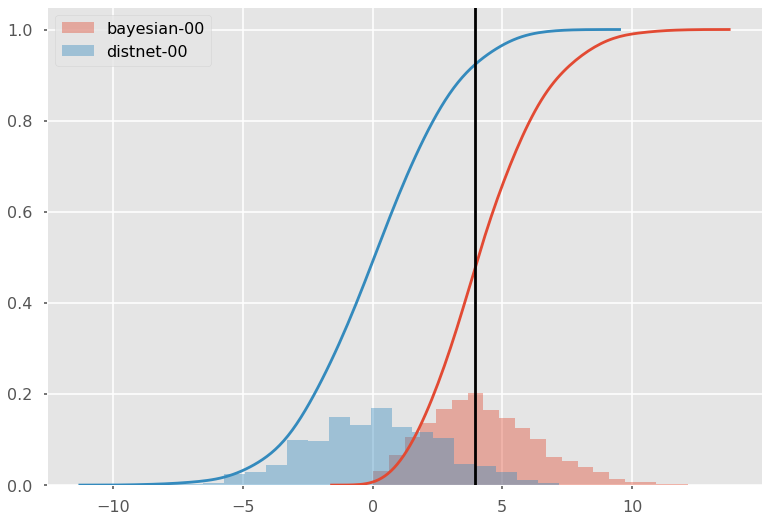

In [297]:
# Load models
model1 = torch.jit.load('../src/export/Bayesian/bayesian_full_lb60_1.pt')
model2 = torch.jit.load('../src/export/DistNet/distnet_full_lb60_1.pt')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load level
# Get specific high level path and standardize
level = ['train4_254', 0]
level_data = torch.load('../../training_data/{}_feature.zip'.format(level[0]))[level[1]]
# t2 = level_data[1]
# for i, row in enumerate(t2):
#     for j, col in enumerate(row):
#         if col != 0:
#             level_data[1][i][j] = 0.0

# indices = [(0,21), (1,21), (1,22),(1,23),(1,24),(1,25),(1,26),(1,27),(1,28),(1,29),(1,30),(1,31),
#           (1,32),(1,33),(1,34),(1,35),(1,36),(1,37),(2,37),(3,37),(4,37),(5,37),(6,37),(7,37),
#           (8,37),(9,37),(10,37),(11,37),(12,37),(13,37),(14,37),(15,37),(16,37),(17,37),(18,37),(19,37),
#           (20,37),(21,37),(22,37),(23,37),(24,37),(25,37),(26,37),(27,37),(28,37),
#           (28,36),(28,35),(28,34),(28,33),(28,32),(28,31),(28,30),(28,29),(28,28),(28,27),(28,26),(28,25),
#           (29,25),(30,25),(31,25),(32,25)]
# values = [(i+1)/len(indices) for i in range(len(indices))]
# for indx, val in zip(indices, values):
#     level_data[1][indx[0]][indx[1]] = val
level_time = np.log(torch.load('../../training_data/{}_observation.zip'.format(level[0]))[level[1]][0].item() + 1e-8)
preprocessLevel(level_data)

models = [model1, model2]
model_names = ['bayesian-00', 'distnet-00']
all_time_points = getLevelRuntimes(models, model_names, level_data)
print('{} {}'.format(np.mean(all_time_points[0][0]), np.var(all_time_points[0][0])))
print('{} {}'.format(np.mean(all_time_points[1][0]), np.var(all_time_points[1][0])))
graphObservations(all_time_points, t=level_time)

# Compare p values

In [124]:
def comparePValues(models, model_names, levels):   
    p_results = []

    # Load level
    # Get specific high level path and standardize
    for i, level in enumerate(levels):
#         print(i)
        level_data = torch.load('../../training_data/{}_feature.zip'.format(level[0]))[level[1]]
        level_time = np.log(torch.load('../../training_data/{}_observation.zip'.format(level[0]))[level[1]][0].item() + 1e-8)
        preprocessLevel(level_data)

        all_time_points = getLevelRuntimes(models, model_names, level_data)
#         p_results.append(compareBayesDistnetProbs(all_time_points, level_time))
        p_results.append(compareBayesDistnetBoth(all_time_points, level_time))
    return p_results

In [18]:
def comparePvaluesFold(lb, k):
    BASE_FILE = '../src/export/DistNet/distnet_key_lb{}_{}.txt'
    BASE_MODEL_BAYES = '../src/export/Bayesian/bayesian_full_lb{}_{}.pt'
    BASE_MODEL_NORM = '../src/export/DistNet/distnet_full_lb{}_{}.pt'

    # Models
    models = [torch.jit.load(BASE_MODEL_BAYES.format(lb, k)), torch.jit.load(BASE_MODEL_NORM.format(lb, k))]
    model_names = ['bayesian-00', 'distnet-00']

    # Get level data
    levels = []
    level_file = open(BASE_FILE.format(lb, k), "r")
    for line in level_file:
        levels.append([line.strip(), 0])

    p_values = comparePValues(models, model_names, levels)
    return p_values

In [103]:
DF_COLUMNS = ['LB', 'Better', 'Worse', 'Even']
DF_COLUMNS = ['LB', 'Better and Different', 'Better and Same', 'Worse and Different', 'Worse and Same', 'Both Bad']
df = pd.DataFrame(columns=DF_COLUMNS)

LBS = ['00', '20', '40', '50', '60', '80']
for lb in LBS:
    print('LB: {}'.format(lb))
    p_values = []
    for k in range(NUM_FOLDS):
        print('Fold {} of {}'.format(k+1, NUM_FOLDS))
        p_values += comparePvaluesFold(lb, k+1)
    
    # Add data
    p_bayes_better_diff = float(p_values.count(1)) / len(p_values) * 100
    p_bayes_better_same = float(p_values.count(2)) / len(p_values) * 100
    p_bayes_worse_diff = float(p_values.count(3)) / len(p_values) * 100
    p_bayes_worse_same = float(p_values.count(4)) / len(p_values) * 100
    p_bayes_even = float(p_values.count(0)) / len(p_values) * 100
    row = (lb, p_bayes_better_diff, p_bayes_better_same, p_bayes_worse_diff, p_bayes_worse_same, p_bayes_even)
    df = df.append(pd.Series(row, index=df.columns), ignore_index=True)
df.to_pickle('compare_likelihoods_full_95.pkl')

LB: 00
Fold 1 of 5
Fold 2 of 5
Fold 3 of 5
Fold 4 of 5
Fold 5 of 5
LB: 20
Fold 1 of 5
Fold 2 of 5
Fold 3 of 5
Fold 4 of 5
Fold 5 of 5
LB: 40
Fold 1 of 5
Fold 2 of 5
Fold 3 of 5
Fold 4 of 5
Fold 5 of 5
LB: 50
Fold 1 of 5
Fold 2 of 5
Fold 3 of 5
Fold 4 of 5
Fold 5 of 5
LB: 60
Fold 1 of 5
Fold 2 of 5
Fold 3 of 5
Fold 4 of 5
Fold 5 of 5
LB: 80
Fold 1 of 5
Fold 2 of 5
Fold 3 of 5
Fold 4 of 5
Fold 5 of 5


In [104]:
df = pd.read_pickle('compare_likelihoods_full_95.pkl')
df

,LB,Better and Different,Better and Same,Worse and Different,Worse and Same,Both Bad
0,00,78.164983,0.0,18.720539,0.0,3.114478
1,20,69.326599,0.0,29.966330,0.0,0.707071
2,40,63.939394,0.0,35.673401,0.0,0.387205
3,50,63.316498,0.0,35.707071,0.0,0.976431
4,60,58.804714,0.0,40.808081,0.0,0.387205
5,80,46.599327,0.0,53.198653,0.0,0.202020


# Method for Tree Search

In [230]:
# Load model
BASE_FILE = '../src/export/DistNet/distnet_key_lb{}_{}.txt'
BASE_MODEL_BAYES = '../src/export/Bayesian/bayesian_full_lb{}_{}.pt'
lb = '00'
k = '1'
model = torch.jit.load(BASE_MODEL_BAYES.format(lb, k))

# load level
level_data = torch.load('../../training_data/{}_feature.zip'.format('train1_1'))[0]
level_time = np.log(torch.load('../../training_data/{}_observation.zip'.format(level[0]))[level[1]][0].item() + 1e-8)
preprocessLevel(level_data)

# Sample
run_times = getLevelRuntimes([model], ['bayesian'], level_data)[0][0]
hist, bin_edges = np.histogram(run_times, 20)
hist = [h if h != 0 else (hist[i-1]+hist[i+1])/2 for i, h in enumerate(hist)]

In [231]:
print(bin_edges)
print(hist)
print(getHistorgramValue(hist, bin_edges, 18))
print(getECDF(run_times, 22))

[ 0.06170438  0.72759418  1.39348398  2.05937378  2.72526358  3.39115338
  4.05704318  4.72293298  5.38882279  6.05471259  6.72060239  7.38649219
  8.05238199  8.71827179  9.38416159 10.05005139 10.71594119 11.38183099
 12.04772079 12.71361059 13.37950039]
[39, 78, 99, 103, 132, 176, 132, 127, 118, 85, 60, 52, 25, 20, 12, 10, 4, 4, 2, 2]
0.0015625
1.0


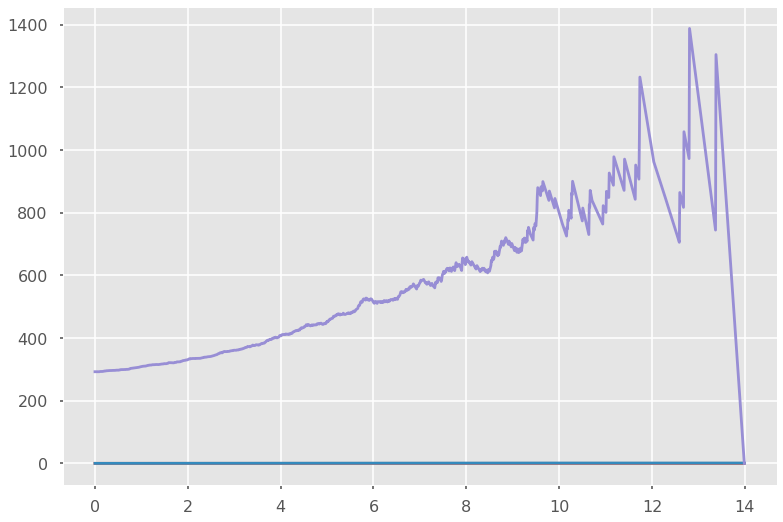

In [258]:
ts = [i/100 for i in range(1400)]
pdfs = [getHistorgramValue(hist, bin_edges, t) for t in ts]
cdfs = [getECDF(run_times, t) for t in ts]
# metrics = [sum([1-cdfs[i2] for i2, ti in enumerate(ts) if ti > t])/(1-cdfs[i1]) for i1, t in enumerate(ts)]
metrics = [sum([pdfs[i2]*ti for i2, ti in enumerate(ts) if ti > t]) /(1-cdfs[i1]) for i1, t in enumerate(ts)]
# hazards = [float(p) / float(1-c) for p, c in zip(pdfs, cdfs)]
sns.lineplot(ts, pdfs)
sns.lineplot(ts, cdfs)
sns.lineplot(ts, metrics)

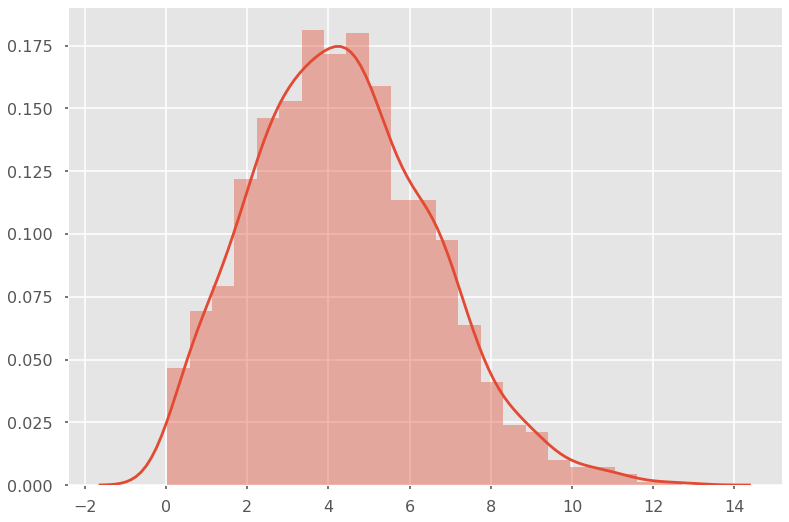

In [226]:
sns.distplot(run_times)
# sns.lineplot(ts, pdfs)

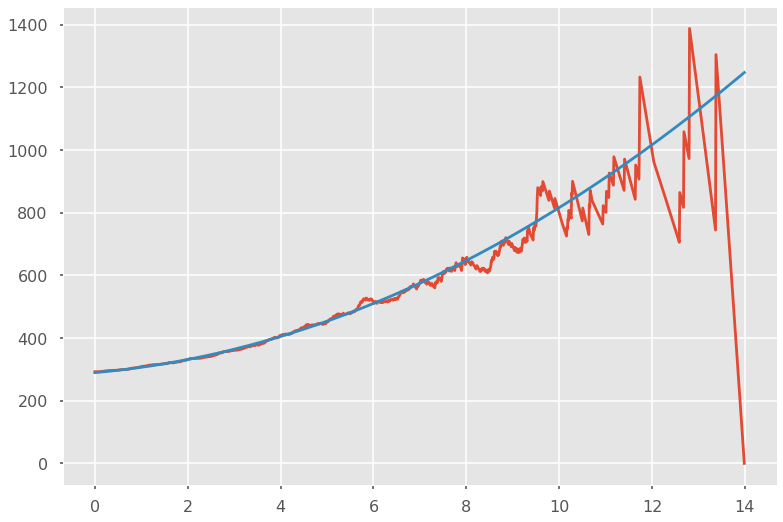

In [275]:
poly_fit = np.polyfit(ts[:len(ts)//2], metrics[:len(metrics)//2], 2)
z = np.poly1d(poly_fit)
zs = [z(t) for t in ts]
sns.lineplot(ts, metrics)
sns.lineplot(ts, zs)

In [292]:
level = ['train4_254', 0]
level_data = torch.load('../../training_data/{}_feature.zip'.format(level[0]))[level[1]]
t1 = level_data[0]
alpha = 'ABCDEFGHIJKLMNOPQRSTUV'
idx = 0
seen = {}
for row in t1:
    for col in row:
        d = col.item()
        if d not in seen:
            seen[d] = alpha[idx]
            idx += 1
        print('{} '.format(seen[d]), end='')
    print()
    
t2 = level_data[1]
for i, row in enumerate(t2):
    for j, col in enumerate(row):
        if col != 0:
            level_data[1][i][j] = 0.0

indices = [(0,21), (1,21), (1,22),(1,23),(1,24),(1,25),(1,26),(1,27),(1,28),(1,29),(1,30),(1,31),
          (1,32),(1,33),(1,34),(1,35),(1,36),(1,37),(2,37),(3,37),(4,37),(5,37),(6,37),(7,37),
          (8,37),(9,37),(10,37),(11,37),(12,37),(13,37),(14,37),(15,37),(16,37),(17,37),(18,37),(19,37),
          (20,37),(21,37),(22,37),(23,37),(24,37),(25,37),(26,37),(27,37),(28,37),
          (28,36),(28,35),(28,34),(28,33),(28,32),(28,31),(28,30),(28,29),(28,28),(28,27),(28,26),(28,25),
          (29,25),(30,25),(31,25),(32,25)]
values = [(i+1)/len(indices) for i in range(len(indices))]
for indx, val in zip(indices, values):
    level_data[1][indx[0]][indx[1]] = val
t2 = level_data[1]
for i, row in enumerate(t2):
    for j, col in enumerate(row):
        print('{:.3f} '.format(col.item()), end='')
    print()

A A A B B B A A A A A A A B A A A A A A A A A A A A A A A A A B B A A A A A A A 
A C A D D D A A A A A A C D D A A A A A A A A A A A A A A A A D D A A A A A A A 
A D A A E A A A A A A A D A A A A A A A A A A A A A A A A A E A A A A F F A A A 
F F F F F F F F F F F F G A G F F F F F F F F F F F F F F F F F F F F F F A A A 
F F F F F F F F F F F F F C F F F F F F F F F F F F F F F F F F F F F F A A A A 
F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F A A A A 
F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F A A A A 
F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F A A A A 
F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F F A A A A 
F F F A A A A A A A A A A A A A A A A A A A A A A A A A A A A A A F F F A A A A 
F F F A A A A A A A A A A A A A A A A A A A A A A A A A A A B B B F F F A A A A 
F F F A A A A A A A A A A A A A A A A A A A A A A A A A A A D D D F F F A A A A 
F F F A A A F F F F F F F F 